## **Recommend - Optimize**

The recommend functionality of twinLab can help you decide what the next best samples to take are. In this Notebook, we'll take a particular look at using the "optimise" acquisition function.

Getting additional points from recommend using the `"optimise"` keyword argument helps you find the next best point to most maximize your emulator's knowledge of it's maximum. Using these points, and getting their subsequent y-values by inputting your x-values into your model, you can then retrain your emulator and improve your understanding of which experimental choices or simulation path to go down. 

In this Jupyter Notebook you will: 

1. [Load an example dataset, and train your emulator.](#1-get-and-train-an-example-dataset)
2. [Predict points with your emulator.](#2-predict-using-your-trained-emulator)
2. [Find new data points from your trained emulator with `Emulator.recommend`.](#3-use-recommend-to-optimise-your-emulator) 
3. [Visualise your results and their uncertainty.](#4-visualise-your-recommend-results)
4. [Explore how to make the most of using your `Emulator.recommend` parameters.](#5-explore-the-parameters) 


Start by importing all the necessary packages you need for this tutorial.

In [1]:
import twinlab as tl


          ====== TwinLab Client Initialisation ======
          Version     : 2.13.0
          User        : jamie@digilab.co.uk
          Server      : https://tq327x8grc.execute-api.eu-west-2.amazonaws.com/dev
          Environment : /Users/jamiedonald-mccann/Desktop/twinLab/tutorials/.env



Make sure you set up your API key and other information to be able to use `twinLab`, either through a `.env` file, using `secrets`, or through `tl.set_user`/`tl.set_api_key`. 

### **1. Get and train an example dataset**

In this tutorial, you'll use the example dataset, "quickstart", which has a single input variable "x" and a single output, or response, variable "y". You might see "input" features also referred to as feature, predictor, or parameter in data science circles. 

In [2]:
# Download the example dataset
df = tl.load_example_dataset("quickstart")

# Check the dataframe before uploading
display(df)

,x,y
0,0.696469,-0.817374
1,0.286139,0.887656
2,0.226851,0.921553
3,0.551315,-0.326334
4,0.719469,-0.832518
5,0.423106,0.400669
6,0.980764,-0.164966
7,0.684830,-0.960764
8,0.480932,0.340115
9,0.392118,0.845795


Using the `upload` method, you can then upload the `Dataset` to your `twinLab` cloud account. 

In [3]:
# Initialise a Dataset object and give it a name
dataset = tl.Dataset("quickstart")

# Upload the dataset, passing in the dataframe
dataset.upload(df)

Next, you need to define your emulator. 

In [4]:
# Initialise emulator
emulator_id = "example_emulator"

emulator = tl.Emulator(id=emulator_id)

When you want to train a model, you pass on your training requirements via arguments using a `TrainParams` object. `TrainParams` is a class that contains all the necessary parameters needed to train your model.

The `TrainParams` object has a lot of other parameters to customise your training including dimensionality reduction, type of estimator, automatic model selection and many others. Please refer to [twinLab-docs](https://twinlab.ai/python/reference/parameters.html#api-parameters) for more information.

In [5]:
# Define the training parameters for your emulator
params = tl.TrainParams(train_test_ratio=1.0)

Then, to train your model, you use the `Emulator.train` function, and input your `TrainParams` object as an argument to this function. 

In this example, we will just define the `train_test_ratio` parameter which specifies the amount of data that has to be allocated to emulator training from your entire dataset.

In [6]:
# Train the emulator using the train method
emulator.train(
    dataset=dataset, inputs=["x"], outputs=["y"], params=params, verbose=True
)

Emulator 'example_emulator' has begun training.
0:00:00: Job status: processing
0:00:01: Job status: success
Training of emulator example_emulator is complete!


### **2. Predict using your trained emulator**

We can use the `Emulator.plot` functionality to plot the mean prediction and the uncertainty band of the emulator.

The `Emulator.plot` function internally uses the `Emulator.predict` function, so we are also predicting by calling this. There are a few arguments that can be passed to the `Emulator.predict` function, which can be done using the `tl.PredictParams` object. Refer to [twinLab Parameter Docs](https://twinlab.ai/python/reference/parameters.html#api-parameters) for more information on the parameter objects.

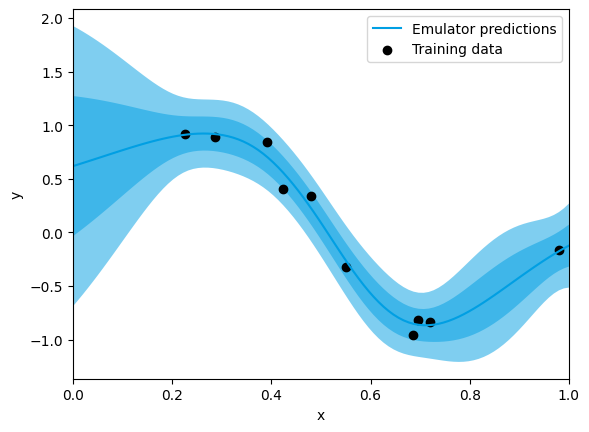

In [7]:
# Plot the trained emulator with the predictions
plt = emulator.plot(x_axis="x", y_axis="y", label="Emulator predictions", x_lim=(0, 1))
# Add on your training data points
plt.scatter(df["x"], df["y"], color="k", label="Training data", zorder=1)
# Make sure to add a legend
plt.legend()
# Once you show the plot you've finalised it's form!
plt.show()

If you check on the processes associated with your emulator, you can see the prediction that you created when using `emulator.plot`.

In [8]:
emulator.list_processes()

['predict-rotating-lead-ornament']

You can get the results of the prediction that was made by taking the `'process_id'` generated during the plot function running and running it through `emulator.get_process`.

In [9]:
process_id = "<INSERT_PROCESS_ID_HERE>"
mean, std = emulator.get_process(process_id=process_id, verbose=True)

Mean predictions:
           y
0   0.618116
1   0.632767
2   0.647590
3   0.662558
4   0.677638
..       ...
95 -0.232815
96 -0.203753
97 -0.175723
98 -0.148787
99 -0.122988

[100 rows x 1 columns]
Standard deviation predictions:
           y
0   0.653885
1   0.633612
2   0.612575
3   0.590800
4   0.568322
..       ...
95  0.187721
96  0.183122
97  0.182553
98  0.186733
99  0.195862

[100 rows x 1 columns]
Process predict-rotating-lead-ornament results:
(           y
0   0.618116
1   0.632767
2   0.647590
3   0.662558
4   0.677638
..       ...
95 -0.232815
96 -0.203753
97 -0.175723
98 -0.148787
99 -0.122988

[100 rows x 1 columns],            y
0   0.653885
1   0.633612
2   0.612575
3   0.590800
4   0.568322
..       ...
95  0.187721
96  0.183122
97  0.182553
98  0.186733
99  0.195862

[100 rows x 1 columns])


### **3. Use recommend to "optimise" your emulator**

Optimise your emulator starting with just the default Recommend parameters so you can see how best to use the function. 

If you utilise the default `verbose` keyword argument, and put `wait` as `False`, that can be helpful if you're waiting on a longer job, as you don't need to wait until the job has finished running on twinLab cloud; you carry on executing other cells!

In [10]:
emulator.recommend(num_points=2, acq_func="optimise", wait=False, verbose=True)

Job recommend process ID: recommend-everlasting-nickel-chalk


'recommend-everlasting-nickel-chalk'

To then check on the progress of your job, you can use `list_processes_statuses` to see what the status of your inference method is until it finishes. 

In [11]:
emulator.list_processes_statuses()

[{'process_id': 'predict-rotating-lead-ornament',
  'status': 'success',
  'start_time': '2024-08-29T14:32:32.538793+00:00',
  'end_time': '2024-08-29T14:32:35.117054+00:00'},
 {'process_id': 'recommend-everlasting-nickel-chalk',
  'status': 'success',
  'start_time': '2024-08-29T14:32:53.684757+00:00',
  'end_time': '2024-08-29T14:32:57.137326+00:00'}]

Using `"optimise"` has returned two objects--two new recommended samples and the acquisition value. These two new recommended samples are suggested input values that would maximize the emulator's knowledge about where the maximum of the emulator is. 

### **4. Visualise your `recommend` results**

Let's visualise the results of `recommend` against what we predicted!

In [12]:
# Recommend more points and assign variables to the results
points, value = emulator.recommend(
    num_points=4, acq_func="optimise", wait=True, verbose=True
)

Job recommend process ID: recommend-coconut-estimated-rutabaga
0:00:00: Job status: processing
0:00:01: Job status: processing
0:00:03: Job status: success
Recommended points:
          x
0  0.226851
1  0.226851
2  0.226851
3  0.411557


Job predict process ID: predict-sassy-extreme-geranium
0:00:00: Job status: processing
0:00:01: Job status: processing
0:00:03: Job status: success
Mean predictions:
           y
0   0.618116
1   0.632767
2   0.647590
3   0.662558
4   0.677638
..       ...
95 -0.232815
96 -0.203753
97 -0.175723
98 -0.148787
99 -0.122988

[100 rows x 1 columns]
Standard deviation predictions:
           y
0   0.653885
1   0.633612
2   0.612575
3   0.590800
4   0.568322
..       ...
95  0.187721
96  0.183122
97  0.182553
98  0.186733
99  0.195862

[100 rows x 1 columns]


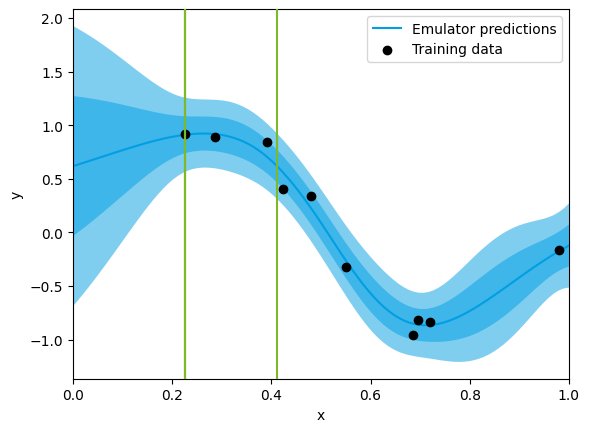

In [13]:
# Create a prediction and plot
plt = emulator.plot(
    x_axis="x", y_axis="y", label="Emulator predictions", x_lim=(0, 1), verbose=True
)
# Add on training data through scatterplot
plt.scatter(df["x"], df["y"], color="black", label="Training data", zorder=2)
# Loop over the recommendation dataframe
for x in range(len(points)):
    # Plot recommendation "x points" as horizontal lines
    plt.axvline(x=points["x"].iloc[x], color="#7DB928", zorder=3)
plt.legend()
plt.show()

### **5. Explore the parameters**

#### Recommend parameters: restarts and samples

Now you can experiment with some of the non-default parameters under the hood of `emulator.recommend`. Increasing the number of random restarts for optimisation (from the default 5), and the number of raw samples that our recommend functions initialise with (from the default 128), can take longer, but scopes out more of your parameter space. 

In [14]:
# Create a recommend parameters object
parameters = tl.RecommendParams(num_restarts=50, raw_samples=200)
# Set up the recommend run with the additional recommend
emulator.recommend(
    num_points=8, acq_func="optimise", params=parameters, wait=False, verbose=True
)

Job recommend process ID: recommend-spotless-observant-salt


'recommend-spotless-observant-salt'

In [16]:
# Get the recommended points with the ID generated from the recommend function
process_id = "<INSERT_PROCESS_ID_HERE>"
more_points, _ = emulator.get_process(process_id=process_id, verbose=True)

Recommended points:
          x
0  0.276957
1  0.324875
2  0.253275
3  0.226851
4  0.754988
5  0.783894
6  0.300409
7  0.630404
Process recommend-spotless-observant-salt results:
(          x
0  0.276957
1  0.324875
2  0.253275
3  0.226851
4  0.754988
5  0.783894
6  0.300409
7  0.630404, -2.787073446061601)


Plot with the predictions and the new recommended points once again:

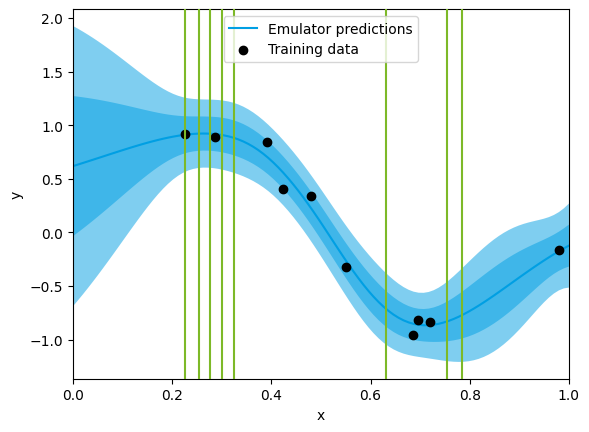

In [17]:
# Create a prediction and plot
plt = emulator.plot(x_axis="x", y_axis="y", label="Emulator predictions", x_lim=(0, 1))
# Add on training data through scatterplot
plt.scatter(df["x"], df["y"], color="black", label="Training data", zorder=2)
# Loop over the recommendation dataframe
for x in range(len(more_points)):
    # Plot recommendation "x points" as horizontal lines
    plt.axvline(x=more_points["x"].iloc[x], color="#7DB928", zorder=3)
plt.legend()
plt.show()

The recommended places for further sampling, the orange lines, are exploring more of the parameter space. 

#### Recommend parameters: bounds

Next set a bound for your recommended points. 

In [18]:
# Create a recommend parameters object
parameters = tl.RecommendParams(bounds={"x": (0.1, 0.5)})
# Set up the recommend run with the additional recommend
emulator.recommend(
    num_points=2, acq_func="optimise", params=parameters, wait=False, verbose=True
)

Job recommend process ID: recommend-rich-pouncing-hovercraft


'recommend-rich-pouncing-hovercraft'

In [19]:
# Get the recommended points with the ID generated from the recommend function
process_id = "<INSERT_PROCESS_ID_HERE>"
bounded_points, _ = emulator.get_process(process_id=process_id, verbose=True)

Recommended points:
     x
0  0.1
1  0.1
Process recommend-rich-pouncing-hovercraft results:
(     x
0  0.1
1  0.1, -2.3421995792862456)


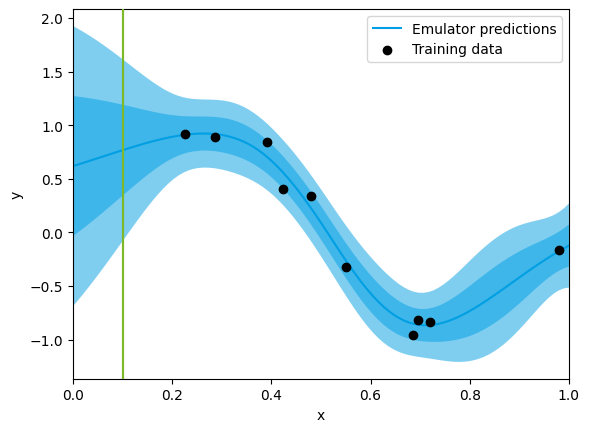

In [20]:
# Create a prediction and plot
plt = emulator.plot(x_axis="x", y_axis="y", label="Emulator predictions", x_lim=(0, 1))
# Add on training data through scatterplot
plt.scatter(df["x"], df["y"], color="black", label="Training data", zorder=2)
# Loop over the recommendation dataframe
for x in range(len(bounded_points)):
    # Plot recommendation "x points" as horizontal lines
    plt.axvline(x=bounded_points["x"].iloc[x], color="#7DB928", zorder=3)
plt.legend()
plt.show()

Setting these bounds might be useful for if you know ahead of time (e.g. some physical reason or process) that you want to constrain the generation of recommended points.

Now that you know how to confidently acquire suggestions for new points, you can run these new suggested x-values through your model to acquire the associated y-values. If you retrain your emulator with these x- and y-values, you can then get an updated emulator to help inform you about how best to update your model or run your next experiment. Make sure to checkout `tl.Emulator.maximize ` as well, to find the point at which you can maximize your emulator. 

### **Deleting datasets and campaigns**

You can delete your datasets and emulators to keep your `twinLab` cloud account storage tidy. 

Please be aware that this is permanent. Always consider keeping your data locally backed up. 

`Emulator.delete` and `Dataset.delete` delete the emulator and the dataset respectively.

In [21]:
# Delete dataset
dataset.delete()

# Delete emulator
emulator.delete()